# RGBChem

RGBChem is a procedure for predicting the properties of chemical compounds using the conversion of chemical properties to RGB images.

In this Jupyter Notebook we present the main ideas of the whole workflow.

## Loading python files from github (Google Colab only)

In [ ]:
!pip -q install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from git import Repo

repo_path = '/content/RGBChem'

repo_url = 'https://github.com/all2gos/RGBChem.git'

Repo.clone_from(repo_url, repo_path)

!mv /content/RGBChem/* .

## Data Preparation

For the purpose of presenting a working demo, we will use a [qm9 database](https://www.nature.com/articles/sdata201422), which contains 133885 organic molecules with up to 9 heavy atoms (CONF).

In [4]:
import pandas as pd
from scripts.dataloaders import dataloader_conv
from scripts.params import *

#this function perform database creation, .png files creation and DataLoader and Dataset PyTorch object creation. Moreover it is possible to create
#a fastai workflow build on that components which we will show you in this demo.

if DELETE == False:
  
    dl = dataloader_conv()
    ds = pd.read_csv(f'{PATH}/{DB}.csv')

else:
    print('DELETE == True') #you probably don't want to set the DELETE == True in this notebook
    ds = pd.read_csv(f'{PATH}/{DB}.csv')


DELETE == True


In [2]:
ds.drop(['cords','mulliken'],axis=1).head() #showing the initial database

,Unnamed: 0,ID,A,B,C,Dipole moment,Isotropic Polarizability,Energy of HOMO,Energy of LUMO,bandgap,...,Free energy at 298K,Heat capacity at 298K,n_atoms,atom_type,Number_of_C,Number_of_F,Number_of_N,Number_of_O,Number_of_H,Sum_of_heavy_atoms
0,0,gdb_28954_0,3.15438,1.13871,0.89620,2.5752,72.32,-0.1927,-0.0333,0.1594,...,-437.952342,31.284,16,"['O', 'C', 'C', 'C', 'C', 'N', 'C', 'C', 'O', ...",6,0,1,2,7,9
1,1,gdb_55093_1,3.94212,1.12008,0.96409,3.6752,77.17,-0.2273,0.0537,0.2809,...,-419.246952,33.586,19,"['C', 'C', 'C', 'C', 'N', 'C', 'C', 'N', 'O', ...",6,0,2,1,10,9
2,2,gdb_11864_2,6.10633,1.06881,1.01038,1.9276,68.68,-0.2572,0.0732,0.3304,...,-384.933156,30.024,18,"['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', ...",6,0,0,2,10,8
3,3,gdb_42935_3,3.19871,1.22243,0.97474,7.2297,69.94,-0.2537,-0.0360,0.2177,...,-416.817700,28.851,15,"['O', 'C', 'C', 'N', 'C', 'C', 'C', 'C', 'N', ...",6,0,2,1,6,9
4,4,gdb_363_4,9.81743,2.15461,1.81196,3.5856,51.35,-0.2383,0.0670,0.3052,...,-303.819322,25.314,14,"['C', 'N', 'C', 'O', 'N', 'C', 'H', 'H', 'H', ...",3,0,2,1,8,6


### Image Creation

The whole procedure is based on the following concepts:

- We represent a molecule with $N$ atoms as a matrix of dimensions $(N+m)\times(N+m)$, where $m$ is some assumed margin that makes all generated images of the same size
- In cells where $i=j$ (i.e., on the diagonal of the matrix), we can put information about properties specific to individual atoms (e.g., atomic charge)
- In all cells we can include information describing the relationship between atom $i$ and $j$. Values for some properties are present in all cells (e.g. Coulomb charge), some are zeroes on diagonal (e.g. Cartesian distance between atoms)
- This leads us to 3 matrices that contain 3 to 6 types of different information.
- We scale all the values in the matrices so that each has values in the range $0-255$.
- In this way, we obtain 3 matrices that are direct information about the scale of each color in the RGB system -> based on this we generate the corresponding images.


One important fact should be kept in mind: a translation or rotation of a molecule does not change its energy or any other property. Still, we can generate lots of images according to the given procedure for the same molecule. We decided to use this fact to augment the data and generate many different images for the same molecule. However in this demo we do not do that.

For one matrix, it is necessary to specify parameters from ReaxFF. So far, the most accessible and efficient way is to paste them into a dictionary directly in notebook.

## Fastai approach

In [5]:
from fastai.vision.all import *
from scripts.params import *
import torch

def get_list(path):
    l = []
    for plik in os.listdir(path):
        if os.path.isfile(os.path.join(path, plik)):
            l.append(plik)
    return l

def get_x(r): return f"{path}/{r['ID']}.png"
def get_y(r): return float(r[PREDICTED_VALUE])



path = f'{PATH}/{TRAIN_DIR_NAME}'
get_image_files = get_list(path)

In [6]:
f = os.listdir(f"{PATH}/{TRAIN_DIR_NAME}")
f = [x[:-4] for x in f]

filtered = ds[ds.ID.isin(f)]
print(f'{len(filtered)} out of {len(ds)} samples were selected')


120492 out of 133885 samples were selected


Current batch size: 64


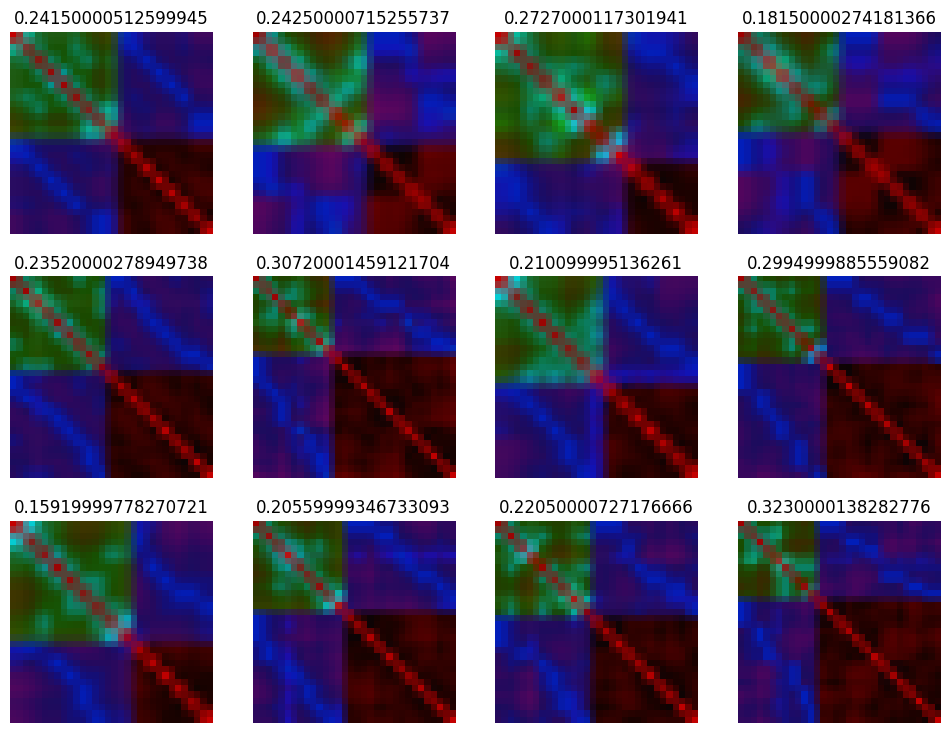

In [7]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=get_x, get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                  item_tfms=Resize(32)).dataloaders(filtered, bs=BATCH_SIZE)

print(f'Current batch size: {dblock.bs}')
dblock.show_batch(max_n=12)

## Training the Model

For the demo purpose, we choose HOMO-LUMO Gap as the property to predict. And because of the simplicity and transparency of the fastai library, we use that library in this demo to carry out the machine learning workflow. We choose a very simple architecture for learning, which takes very little time to train.

In the standard workflow, we will build the model using clear PyTorch to have more control over the training process.

In [ ]:
learn = vision_learner(dblock, resnet18, metrics=mae, lr=LEARNING_RATE)
saving_callbacks = SaveModelCallback(monitor='valid_loss', comp=np.less, min_delta=DELTA, fname=f"{PATH}/{LOG_FILE.replace('.log','checkpoint_fastai')}")
early_stopping_cb = EarlyStoppingCallback (monitor='valid_loss', comp=np.less, min_delta=DELTA, patience=PATIENCE)

#learn = load_learner('qm9_e512_bandgap_bs64_fastai.pth')

#learn.validate()
learn.fine_tune(EPOCHS, cbs=[early_stopping_cb, saving_callbacks]) #~2 minutes training on T4 GPU
#learn.export(f"{PATH}/{LOG_FILE.replace('.log','_fastai')}")

epoch,train_loss,valid_loss,mae,time
0,0.010728,0.003950,0.048179,00:51


Better model found at epoch 0 with valid_loss value: 0.003950232639908791.


epoch,train_loss,valid_loss,mae,time
0,0.002458,0.001389,0.030378,01:08
1,0.002082,0.001164,0.027504,01:08
2,0.001806,0.001052,0.025393,01:09
3,0.001797,0.001067,0.025611,01:07
4,0.001469,0.000858,0.022836,01:06
5,0.001460,0.000931,0.023412,01:07
6,0.001259,0.000826,0.022115,01:07
7,0.001212,0.000736,0.020988,01:07
8,0.001146,0.000644,0.019535,01:07
9,0.001003,0.000714,0.021053,01:07


Better model found at epoch 0 with valid_loss value: 0.0013891421258449554.
Better model found at epoch 1 with valid_loss value: 0.0011644173646345735.
Better model found at epoch 2 with valid_loss value: 0.001052030478604138.
Better model found at epoch 4 with valid_loss value: 0.0008584170718677342.
Better model found at epoch 6 with valid_loss value: 0.0008256350993178785.
Better model found at epoch 7 with valid_loss value: 0.0007356714340858161.
Better model found at epoch 8 with valid_loss value: 0.0006442451267503202.
Better model found at epoch 10 with valid_loss value: 0.0005781838553957641.
Better model found at epoch 12 with valid_loss value: 0.0005220903549343348.
Better model found at epoch 14 with valid_loss value: 0.000513688602950424.
Better model found at epoch 16 with valid_loss value: 0.0005063958233222365.
Better model found at epoch 17 with valid_loss value: 0.0004559513763524592.
Better model found at epoch 24 with valid_loss value: 0.0004076429468113929.
Better m

In [6]:
test_files = os.listdir(f"{PATH}/{TEST_DIR_NAME}")
test_data = [PILImage.create(f'{PATH}/{TEST_DIR_NAME}/{file}') for file in test_files]
test_dl = learn.dls.test_dl(test_data)
preds, _ = learn.get_preds(dl=test_dl)

err = []
for idx in range(len(test_files)):
    print(f'\r{idx/len(test_files):.2f}',end='')
    actual = ds[PREDICTED_VALUE].loc[ds.ID == test_files[idx][:-4]].values[0]
    err.append(np.abs(preds[idx].item() - float(actual)))

print(f"\n Average prediction error on test set: {sum(err)/len(err)*27211:.2f} meV")

1.00
 Average prediction error on test set: 811.07 meV


## Saving log file

In [7]:
with open(LOG_FILE, 'w+') as file:

    print(f"\n Average prediction error on test set: {sum(err)/len(err)*27211:.2f} meV", file=file)    
    print(f'Copy of a params.py settings:', file=file)
    from scripts.params import __all__
    for name in __all__:
        print(f"{name} = {globals()[name]}", file=file)


model_file = LOG_FILE.replace('.log','checkpoint_fastai')
#!mv LOG_FILE model_file $HOME